In [1]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np
import seaborn as sns


#This file is for development. Main functions are embedded here.

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

#Set peak detection threshold method

refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos_2.ref"

MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

#Read in sample list and load MS data

file="RMB_190828_BATSpooled_30"
bfile="RMB_190828_BATS24_blnk"
MSfiles={}

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
bparser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+bfile)

MSfiles[file]=parser


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


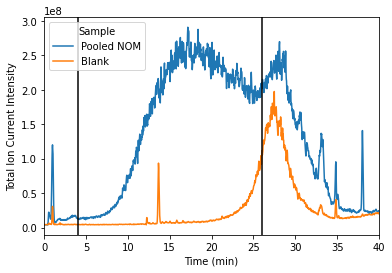

In [3]:
#Plot total ion chromatograms to evaluate useful time range. 

tic=parser.get_tic(ms_type='MS')[0]
btic=bparser.get_tic(ms_type='MS')[0]

#tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
btic_df=pd.DataFrame({'Time': btic.time,'Intensity': btic.tic,'Sample':'Blank'})

tic_df=pd.concat([tic_df,btic_df])
tic_df=tic_df.reset_index()

fig, (ax) = plt.subplots(1)
sns.lineplot(x='Time',y='Intensity',data=tic_df,ax=ax, hue='Sample')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Total Ion Current Intensity')
ax.set_xlim(0,40)
ax.axvline(x=4,color='black')
ax.axvline(x=26,color='black')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig(file_location+'CoreLCMS_FigS1.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS1.pdf',dpi=300,format='pdf')



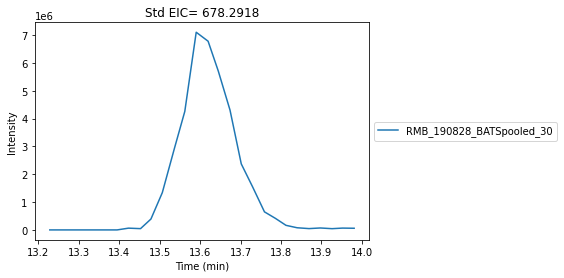

In [6]:
#Plot internal standard (cyanocobalamin)

stdmass=678.2918
std_timerange=[13.2,14]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

In [4]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[4,26]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()
        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-2.0, 2.0),
                                                    calib_snr_threshold=4)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [5]:
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,30)
MSParameters.molecular_search.usedAtoms['N'] = (0,8)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,1)
MSParameters.molecular_search.usedAtoms['Na'] = (0,1)

#MSpeak highest confidence molecular formula. 

#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'pooled_results_wide.csv')

RMB_190828_BATSpooled_30
MS Obj loaded - 449 peaks found.
MS Obj loaded - 449 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 856 fn evals and 20 iterations
'runworker'  1491.53 ms


Loading molecular formula database: 236559it [00:15, 14817.50it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 145.92it/s]        
Loading molecular formula database: 238152it [00:15, 15141.94it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 127.16it/s]
Loading molecular formula database: 237386it [00:18, 12595.95it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 132.28it/s]        
Loading molecular formula database: 240051it [00:15, 15400.56it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 170.62it/s]
Loading molecular formula database: 237951it [00:17, 13633.06it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  136433.44 ms
420 assigned peaks and 29 unassigned peaks, total  = 93.54 %, relative abundance = 87.17 %, RMS error (best candidate) (ppm) = 0.062
MS Obj loaded - 685 peaks found.
MS Obj loaded - 685 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
302 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 860 fn evals and 20 iterations
'runworker'  1170.36 ms


Loading molecular formula database: 236559it [00:15, 14838.03it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 117.76it/s]        
Loading molecular formula database: 238152it [00:18, 12632.87it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 123.60it/s]
Loading molecular formula database: 237386it [00:18, 12959.34it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 144.02it/s]        
Loading molecular formula database: 240051it [00:18, 12855.80it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 145.31it/s]
Loading molecular formula database: 237951it [00:17, 13236.97it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  146411.68 ms
662 assigned peaks and 23 unassigned peaks, total  = 96.64 %, relative abundance = 92.91 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 812 peaks found.
MS Obj loaded - 812 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
369 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  1500.65 ms


Loading molecular formula database: 236559it [00:18, 12966.73it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 100.26it/s]        
Loading molecular formula database: 238152it [00:17, 13586.45it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 62.69it/s] 
Loading molecular formula database: 237386it [00:19, 12184.89it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 119.79it/s]        
Loading molecular formula database: 240051it [00:14, 16671.86it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 120.30it/s]
Loading molecular formula database: 237951it [00:16, 14602.96it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  143137.95 ms
796 assigned peaks and 16 unassigned peaks, total  = 98.03 %, relative abundance = 97.28 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 941 peaks found.
MS Obj loaded - 941 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
446 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3005 fn evals and 69 iterations
'runworker'  1431.20 ms


Loading molecular formula database: 236559it [00:15, 15482.68it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 89.48it/s]        
Loading molecular formula database: 238152it [00:17, 13953.78it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 99.90it/s] 
Loading molecular formula database: 237386it [00:16, 14583.45it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 115.25it/s]        
Loading molecular formula database: 240051it [00:14, 16442.31it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 117.30it/s]
Loading molecular formula database: 237951it [00:16, 14509.74it/s]
Started molecular formula search for class {"N"

'run_molecular_formula'  136898.47 ms
928 assigned peaks and 13 unassigned peaks, total  = 98.62 %, relative abundance = 98.95 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1041 peaks found.
MS Obj loaded - 1041 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3036 fn evals and 67 iterations
'runworker'  1143.11 ms


Loading molecular formula database: 236559it [00:16, 14623.34it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 86.19it/s]         
Loading molecular formula database: 238152it [00:18, 12543.15it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 88.63it/s] 
Loading molecular formula database: 237386it [00:15, 14863.43it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 90.65it/s]         
Loading molecular formula database: 240051it [00:18, 13030.80it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 99.87it/s] 
Loading molecular formula database: 237951it [00:16, 14288.69it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  148005.70 ms
1019 assigned peaks and 22 unassigned peaks, total  = 97.89 %, relative abundance = 97.72 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1047 peaks found.
MS Obj loaded - 1047 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
485 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  860.47 ms


Loading molecular formula database: 236559it [00:17, 13903.13it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.91it/s]        
Loading molecular formula database: 238152it [00:18, 12648.07it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 91.59it/s] 
Loading molecular formula database: 237386it [00:16, 14695.82it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 103.43it/s]        
Loading molecular formula database: 240051it [00:18, 13066.89it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 99.77it/s] 
Loading molecular formula database: 237951it [00:17, 13315.12it/s]
Started molecular formula search for class {"N"

'run_molecular_formula'  150288.43 ms
1032 assigned peaks and 15 unassigned peaks, total  = 98.57 %, relative abundance = 97.78 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 1128 peaks found.
MS Obj loaded - 1128 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  858.20 ms


Loading molecular formula database: 236559it [00:17, 13611.66it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 79.74it/s]         
Loading molecular formula database: 238152it [00:22, 10547.05it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 48.14it/s]
Loading molecular formula database: 237386it [00:24, 9519.67it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 93.83it/s]         
Loading molecular formula database: 240051it [00:20, 11853.46it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 93.80it/s] 
Loading molecular formula database: 237951it [00:23, 10016.46it/s]
Started molecular formula search for class {"N"

'run_molecular_formula'  185495.88 ms
1112 assigned peaks and 16 unassigned peaks, total  = 98.58 %, relative abundance = 97.46 %, RMS error (best candidate) (ppm) = 0.053
MS Obj loaded - 1413 peaks found.
MS Obj loaded - 1413 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
542 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  1449.94 ms


Loading molecular formula database: 236559it [00:18, 12619.03it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 68.85it/s]         
Loading molecular formula database: 238152it [00:25, 9279.53it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 68.18it/s]
Loading molecular formula database: 237386it [00:20, 11706.41it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 85.87it/s]         
Loading molecular formula database: 240051it [00:24, 9711.45it/s] 
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 75.45it/s] 
Loading molecular formula database: 237951it [00:24, 9703.66it/s] 
Started molecular formula search for class {"N"

'run_molecular_formula'  188377.36 ms
1366 assigned peaks and 47 unassigned peaks, total  = 96.67 %, relative abundance = 97.76 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 1349 peaks found.
MS Obj loaded - 1349 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
470 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 472 fn evals and 10 iterations
'runworker'  1214.55 ms


Loading molecular formula database: 236559it [00:18, 13117.03it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 49.52it/s]        
Loading molecular formula database: 238152it [00:19, 12052.41it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.06it/s] 
Loading molecular formula database: 237386it [00:20, 11702.29it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 87.59it/s]         
Loading molecular formula database: 240051it [00:21, 11034.65it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 92.80it/s] 
Loading molecular formula database: 237951it [00:20, 11790.49it/s]
Started molecular formula search for class {"N"

'run_molecular_formula'  173719.41 ms
1310 assigned peaks and 39 unassigned peaks, total  = 97.11 %, relative abundance = 96.18 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1298 peaks found.
MS Obj loaded - 1298 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
352 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3037 fn evals and 71 iterations
'runworker'  796.00 ms


Loading molecular formula database: 236559it [00:16, 13998.31it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 79.45it/s]         
Loading molecular formula database: 238152it [00:19, 12017.00it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 87.52it/s] 
Loading molecular formula database: 237386it [00:21, 11248.60it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 73.36it/s]         
Loading molecular formula database: 240051it [00:18, 12669.52it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 93.19it/s] 
Loading molecular formula database: 237951it [00:22, 10812.28it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  169391.27 ms
1248 assigned peaks and 50 unassigned peaks, total  = 96.15 %, relative abundance = 95.21 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1147 peaks found.
MS Obj loaded - 1147 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
208 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 3039 fn evals and 69 iterations
'runworker'  1085.97 ms


Loading molecular formula database: 236559it [00:19, 12392.24it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 8, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 85.68it/s]         
Loading molecular formula database: 238152it [00:18, 12809.13it/s]
Started molecular formula search for class {"N": 2, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 96.41it/s] 
Loading molecular formula database: 237386it [00:18, 13019.59it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 23, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 104.33it/s]        
Loading molecular formula database: 240051it [00:20, 11453.41it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 30, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 108.59it/s]
Loading molecular formula database: 237951it [00:21, 11079.28it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  164465.91 ms
1106 assigned peaks and 41 unassigned peaks, total  = 96.43 %, relative abundance = 97.10 %, RMS error (best candidate) (ppm) = 0.056


range(200, 800, 200)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


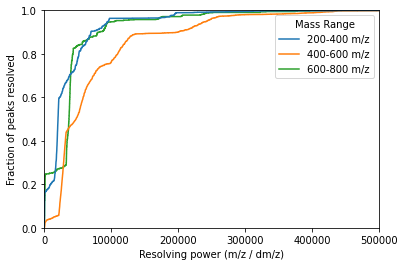

In [6]:
#Make plots showing required resolving power.

res_summary=[]
mzinterval=200
mzint=range(200,800,mzinterval)
print(mzint)
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():

        result_sub=result[result['File']==file]

        for mz in mzint:
            result_sub_mz=result_sub[(result_sub['m/z']>mz) & (result_sub['m/z'] < mz + mzinterval)]
            mzvalues=result_sub_mz['m/z'].sort_values(ascending=True)
            differences=mzvalues.diff()

            #Resolve from peaks on either side
            mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
            mzdiff=mzdiff.min(axis=1)
            mzvalues=mzvalues.iloc[1:-1].reset_index()['m/z']
            mzdiff_res=mzvalues/mzdiff*2
            for i in mzdiff_res.index:
                res_summary.append({'resolution':mzdiff_res[i],'mass':mzvalues[i],'Mass Range':str(mz)+'-'+str(mz+mzinterval) + ' m/z','file':file,'time':time})

res_summary_df=pd.DataFrame(res_summary)
fig, (ax) = plt.subplots(1)
sns.ecdfplot(x='resolution',hue='Mass Range',data=res_summary_df,ax=ax)
ax.set_xlim(0,500000)
ax.set_xlabel('Resolving power (m/z / dm/z)')
ax.set_ylabel('Fraction of peaks resolved')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig(file_location+'CoreLCMS_FigS2.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS2.pdf',dpi=300,format='pdf')




Unique molecular formula #: 3031
Unique m/z peaks: 3433
All assignments: 9513
Good assignments: 9112
Questionable assignments: 401


AttributeError: 'PathCollection' object has no property 'scatter_kws'

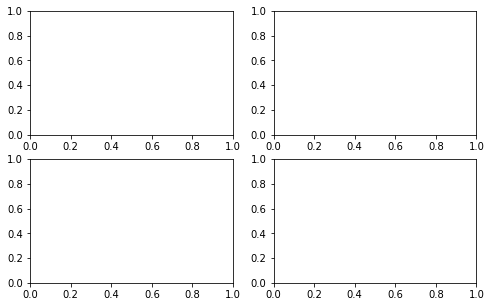

In [11]:
# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['S']=allresults['S'].fillna(0)
allresults['P']=allresults['P'].fillna(0)
allresults['Na']=allresults['Na'].fillna(0)

allresults['Molecular class']='Unassigned'
allresults['Molecular class'][allresults['C']>0]='CHO'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>4.5)]='CHON>4'
allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
allresults['Molecular class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5)]='CHONS'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5)]='CHONP'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5)]='CHOSP'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['Na']>0.5)]='CHONNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHOPNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHOSNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['P']>0.5)]='CHONSP'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHONSNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONPNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONSNa'

results=allresults[allresults['Is Isotopologue']==0]

results_1=results[(results['Molecular class'].isin(['CHO','CHON']))]
results_2=results[(~results['Molecular class'].isin(['CHO','CHON']))]

#results_2=results[(results['Molecular class']!='CHO') | (results['Molecular class']!='CHON<4')]


Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

print('All assignments:', len(results))
print('Good assignments:', len(results_1))
print('Questionable assignments:', len(results_2))




fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(8, 5)


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_1,ax=ax1, edgecolor='none',scatter_kws={'alpha':0.15})
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax1.set_xlim(200,800)
sns.kdeplot(x='m/z Error (ppm)',data=results_1,hue='Molecular class',ax=ax2,legend=False)
ax2.set_xlim(-0.3,0.3)
fig.tight_layout()


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_2,ax=ax3, edgecolor='none',scatter_kws={'alpha':0.15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax3.set_xlim(200,800)
sns.kdeplot(x='m/z Error (ppm)',data=results_2,hue='Molecular class',ax=ax4,legend=False)
ax4.set_xlim(-0.3,0.3)
fig.tight_layout()

fig.savefig(file_location+'CoreLCMS_FigS3.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS3.pdf',dpi=300,format='pdf')

assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['Molecular class'].unique()):
        current[mol_class]=len(allresults[(allresults['Molecular class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)
df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)



plt.show()

In [48]:
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,30)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,0)

Heteroatoms=['N']

#MSpeak highest confidence molecular formula. 

#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_2_df=pd.concat(masterresults.values())
masterresults_2_df.to_csv(file_location+'pooled_results_narrow.csv')

RMB_190828_BATSpooled_30
MS Obj loaded - 449 peaks found.
MS Obj loaded - 449 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 856 fn evals and 20 iterations
'runworker'  2520.03 ms


Loading molecular formula database: 125378it [00:09, 13888.74it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 122.71it/s]


'run_molecular_formula'  12869.34 ms
371 assigned peaks and 78 unassigned peaks, total  = 82.63 %, relative abundance = 69.54 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 685 peaks found.
MS Obj loaded - 685 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
302 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 860 fn evals and 20 iterations
'runworker'  1926.73 ms


Loading molecular formula database: 125378it [00:09, 13198.41it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 83.81it/s] 


'run_molecular_formula'  13343.77 ms
613 assigned peaks and 72 unassigned peaks, total  = 89.49 %, relative abundance = 82.74 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 812 peaks found.
MS Obj loaded - 812 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
369 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  1368.19 ms


Loading molecular formula database: 125378it [00:09, 13102.12it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 84.98it/s] 


'run_molecular_formula'  12819.21 ms
765 assigned peaks and 47 unassigned peaks, total  = 94.21 %, relative abundance = 93.24 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 941 peaks found.
MS Obj loaded - 941 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
446 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3005 fn evals and 69 iterations
'runworker'  1153.85 ms


Loading molecular formula database: 125378it [00:09, 12665.55it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 72.40it/s]


'run_molecular_formula'  13235.23 ms
913 assigned peaks and 28 unassigned peaks, total  = 97.02 %, relative abundance = 97.80 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 1041 peaks found.
MS Obj loaded - 1041 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3036 fn evals and 67 iterations
'runworker'  1711.77 ms


Loading molecular formula database: 125378it [00:11, 11229.61it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 62.89it/s]


'run_molecular_formula'  15391.40 ms
1005 assigned peaks and 36 unassigned peaks, total  = 96.54 %, relative abundance = 96.99 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 1047 peaks found.
MS Obj loaded - 1047 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
485 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1193.03 ms


Loading molecular formula database: 125378it [00:10, 11754.84it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 65.59it/s]


'run_molecular_formula'  14287.21 ms
1010 assigned peaks and 37 unassigned peaks, total  = 96.47 %, relative abundance = 96.58 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 1128 peaks found.
MS Obj loaded - 1128 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1305.90 ms


Loading molecular formula database: 125378it [00:12, 10276.03it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:03<00:00, 46.22it/s]


'run_molecular_formula'  16929.23 ms
1094 assigned peaks and 34 unassigned peaks, total  = 96.99 %, relative abundance = 95.86 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1413 peaks found.
MS Obj loaded - 1413 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
542 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  1609.96 ms


Loading molecular formula database: 125378it [00:12, 10002.52it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:03<00:00, 42.97it/s]


'run_molecular_formula'  17790.35 ms
1335 assigned peaks and 78 unassigned peaks, total  = 94.48 %, relative abundance = 95.92 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1349 peaks found.
MS Obj loaded - 1349 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
470 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 472 fn evals and 10 iterations
'runworker'  1176.58 ms


Loading molecular formula database: 125378it [00:11, 11264.79it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 52.15it/s]


'run_molecular_formula'  15356.33 ms
1263 assigned peaks and 86 unassigned peaks, total  = 93.62 %, relative abundance = 93.84 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1298 peaks found.
MS Obj loaded - 1298 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
352 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3037 fn evals and 71 iterations
'runworker'  2885.76 ms


Loading molecular formula database: 125378it [00:24, 5151.39it/s] 
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:03<00:00, 39.07it/s]


'run_molecular_formula'  31346.17 ms
1163 assigned peaks and 135 unassigned peaks, total  = 89.60 %, relative abundance = 88.22 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 1147 peaks found.
MS Obj loaded - 1147 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
208 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 3039 fn evals and 69 iterations
'runworker'  753.59 ms


Loading molecular formula database: 125378it [00:11, 10796.84it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 59.11it/s]


'run_molecular_formula'  15075.50 ms
991 assigned peaks and 156 unassigned peaks, total  = 86.40 %, relative abundance = 90.18 %, RMS error (best candidate) (ppm) = 0.050


Average Total: 11309.0
Unique  molecular formula #: 3216
Unique good molecular formula #: 3031
Unique m/z peaks: 3433


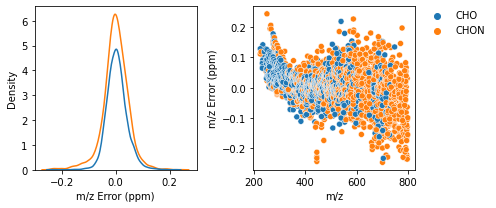

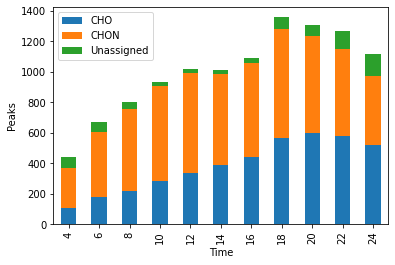

In [77]:
# Plot formula assignment details
allresults=masterresults_2_df[(masterresults_2_df['m/z']<800) & (masterresults_2_df['S/N']>2)]

allresults['O']=allresults['O'].fillna(0)

for element in Heteroatoms:
    allresults[element]=allresults[element].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'

results=allresults[allresults['Is Isotopologue']==0]


print('Average Total:', len(masterresults_df)/len(MSfiles))
print('Unique  molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))


fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(7, 3)

sns.kdeplot(x='m/z Error (ppm)',data=results,hue='mol_class',ax=ax1,legend=False)
ax1.set_xlim(-0.3,0.3)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=results,ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
fig.tight_layout()


assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')


plt.show()


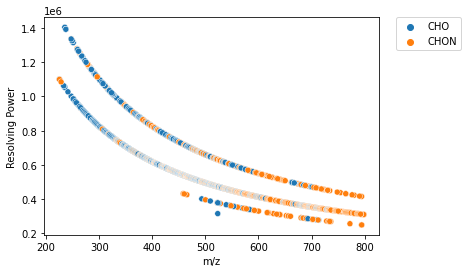

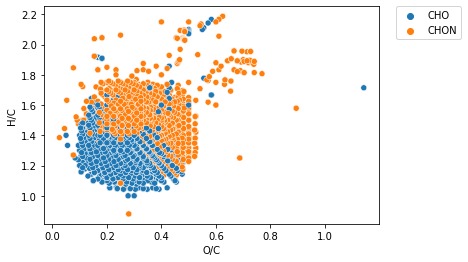

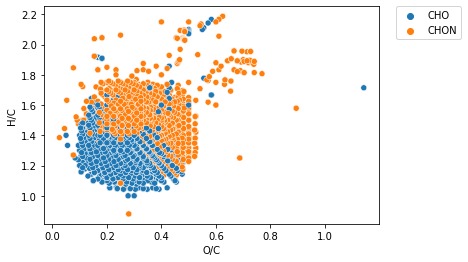

In [148]:
####

fig, (ax) = plt.subplots(1)
ax=sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, (ax) = plt.subplots(1)
ax=sns.scatterplot(x='O/C',y='H/C',hue='mol_class',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, (ax) = plt.subplots(1)
ax=sns.scatterplot(x='O/C',y='H/C',hue='mol_class',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
